Number of unique classes in st_spectype: 481
Filtered classes, remaining unique classes: 237


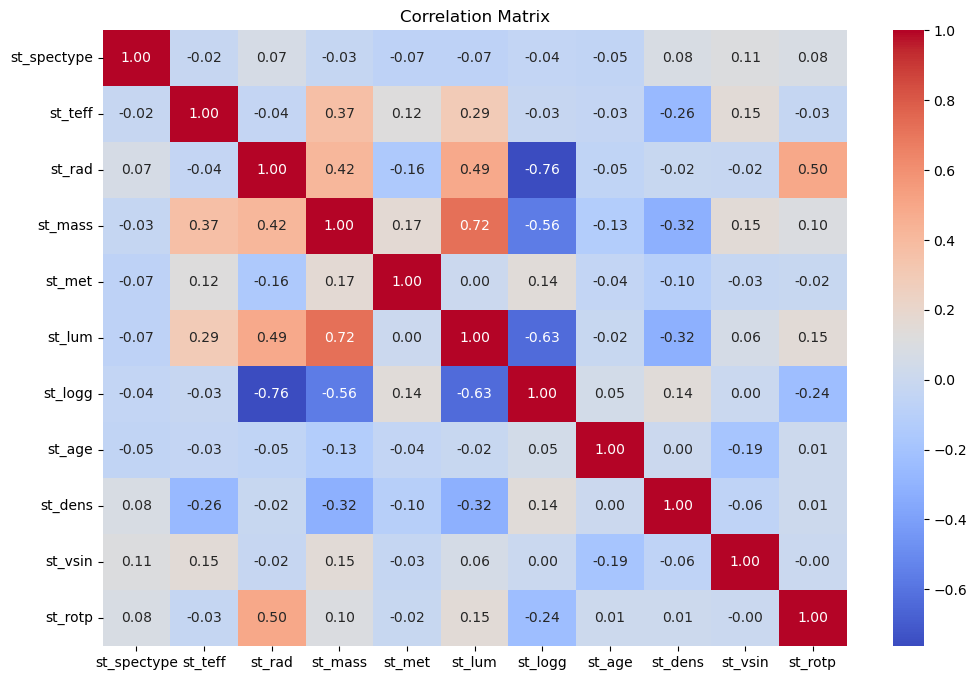

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
file_path = 'STELLARHOSTS.csv'
df = pd.read_csv(file_path)

df_cleaned = df.dropna(subset=['st_spectype'])
df_cleaned = df_cleaned.fillna(df_cleaned.mean(numeric_only=True)) 
 
print(f"Number of unique classes in st_spectype: {df_cleaned['st_spectype'].nunique()}")
label_encoder = LabelEncoder()
df_cleaned['st_spectype'] = label_encoder.fit_transform(df_cleaned['st_spectype'])
 
class_counts = df_cleaned['st_spectype'].value_counts()
valid_classes = class_counts[class_counts > 1].index
df_cleaned = df_cleaned[df_cleaned['st_spectype'].isin(valid_classes)]
print(f"Filtered classes, remaining unique classes: {df_cleaned['st_spectype'].nunique()}")

valid_classes_map = {old_class: new_class for new_class, old_class in enumerate(valid_classes)}
df_cleaned['st_spectype'] = df_cleaned['st_spectype'].map(valid_classes_map)

X = df_cleaned.drop(columns=['st_spectype', 'hostname'])
y = df_cleaned['st_spectype']

df_cleaned['st_spectype'] = y  
numeric_cols = df_cleaned.select_dtypes(include=[np.number])
corr_matrix = numeric_cols.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

hidden_sizes = [16, 32, 64]  
depths = [2, 3, 4]  
learning_rates = [0.0001, 0.0002, 0.0003, 0.001]  
epochs = 500  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"X_train shape: {X_train_scaled.shape}, X_test shape: {X_test_scaled.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

input_size = X_train.shape[1]  
output_size = len(np.unique(y_train))  

def initialize_weights(input_size, hidden_size, output_size, num_hidden_layers):
    np.random.seed(42)
    weights = {}
    
    for i in range(1, num_hidden_layers + 1):
        if i == 1:
            weights[f'W{i}'] = np.random.randn(input_size, hidden_size) * np.sqrt(2. / input_size)
        else:
            weights[f'W{i}'] = np.random.randn(hidden_size, hidden_size) * np.sqrt(2. / hidden_size)
        weights[f'b{i}'] = np.zeros((1, hidden_size))
    
    weights[f'W{num_hidden_layers + 1}'] = np.random.randn(hidden_size, output_size) * np.sqrt(2. / hidden_size)
    weights[f'b{num_hidden_layers + 1}'] = np.zeros((1, output_size))
    
    return weights

def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))  
    return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

def forward_propagation(X, weights, num_hidden_layers):
    activations = {}
    A = X
    for i in range(1, num_hidden_layers + 1):
        Z = np.dot(A, weights[f'W{i}']) + weights[f'b{i}']
        A = np.maximum(0, Z)  
        activations[f'Z{i}'] = Z
        activations[f'A{i}'] = A

    Z_out = np.dot(A, weights[f'W{num_hidden_layers + 1}']) + weights[f'b{num_hidden_layers + 1}']
    A_out = softmax(Z_out)
    activations[f'Z{num_hidden_layers + 1}'] = Z_out
    activations[f'A{num_hidden_layers + 1}'] = A_out
    
    return activations

def compute_loss(y, A_out):
    m = y.shape[0]
    y_onehot = np.zeros((m, output_size))
    y_onehot[np.arange(m), y] = 1  
    log_probs = -np.log(A_out + 1e-10) 
    loss = (1 / m) * np.sum(np.sum(y_onehot * log_probs, axis=1)) 
    return loss

def backward_propagation(X, y, weights, activations, num_hidden_layers):
    gradients = {}
    m = y.shape[0]

    y_onehot = np.zeros((m, output_size))
    y_onehot[np.arange(m), y] = 1

    dZ = activations[f'A{num_hidden_layers + 1}'] - y_onehot
    gradients[f'dW{num_hidden_layers + 1}'] = (1 / m) * np.dot(activations[f'A{num_hidden_layers}'].T, dZ)
    gradients[f'db{num_hidden_layers + 1}'] = (1 / m) * np.sum(dZ, axis=0, keepdims=True)

    for i in range(num_hidden_layers, 0, -1):
        dZ = np.dot(dZ, weights[f'W{i + 1}'].T) * (activations[f'A{i}'] > 0) 
        gradients[f'dW{i}'] = (1 / m) * np.dot((X if i == 1 else activations[f'A{i - 1}']).T, dZ)
        gradients[f'db{i}'] = (1 / m) * np.sum(dZ, axis=0, keepdims=True)

    return gradients

def evaluate_model(X, y, weights, num_hidden_layers=2):
    activations = forward_propagation(X, weights, num_hidden_layers)
    predictions = np.argmax(activations[f'A{num_hidden_layers + 1}'], axis=1)  
    accuracy = np.mean(predictions == y)  
    return accuracy

results = []  
for hidden_size in hidden_sizes:
    for depth in depths:
        for lr in learning_rates:
            weights = initialize_weights(input_size, hidden_size, output_size, depth)
            losses = [] 

            for epoch in range(epochs):
                activations = forward_propagation(X_train_scaled, weights, depth)
                loss = compute_loss(y_train.to_numpy(), activations[f'A{depth + 1}'])
                losses.append(loss)

                gradients = backward_propagation(X_train_scaled, y_train.to_numpy(), weights, activations, depth)
                for i in range(1, depth + 2):
                    weights[f'W{i}'] -= lr * gradients[f'dW{i}']
                    weights[f'b{i}'] -= lr * gradients[f'db{i}']

            train_accuracy = evaluate_model(X_train_scaled, y_train.to_numpy(), weights, depth)
            test_accuracy = evaluate_model(X_test_scaled, y_test.to_numpy(), weights, depth)
            results.append((hidden_size, depth, lr, train_accuracy, test_accuracy))
           
top_5_results = sorted(results, key=lambda x: x[4], reverse=True)[:5]

print("\nTop 5 Performing Configurations:")
for result in top_5_results:
    print(f"Hidden Size: {result[0]}, Depth: {result[1]}, Learning Rate: {result[2]}, Train Accuracy: {result[3]:.4f}, Test Accuracy: {result[4]:.4f}")

X_train shape: (2070, 10), X_test shape: (888, 10)
y_train shape: (2070,), y_test shape: (888,)

Top 5 Performing Configurations:
Hidden Size: 64, Depth: 4, Learning Rate: 0.001, Train Accuracy: 0.0531, Test Accuracy: 0.0631
Hidden Size: 32, Depth: 3, Learning Rate: 0.001, Train Accuracy: 0.0551, Test Accuracy: 0.0597
Hidden Size: 16, Depth: 2, Learning Rate: 0.001, Train Accuracy: 0.0522, Test Accuracy: 0.0586
Hidden Size: 64, Depth: 4, Learning Rate: 0.0002, Train Accuracy: 0.0527, Test Accuracy: 0.0586
Hidden Size: 64, Depth: 4, Learning Rate: 0.0003, Train Accuracy: 0.0527, Test Accuracy: 0.0586
